# Colab setup

Preparazione dell'ambiente di esecuzione del colab notebook. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Colab_yelp/Yelp-Data-Analysis

In [ ]:
! git pull

In [ ]:
! pip install -q -U "tensorflow-text==2.8.*"
! pip install -q tf-models-official==2.7.0
! pip install keras-tuner

# TASK 3

Ogni recensione lasciata sul sito Yelp può ricevere feedback da altri utenti, che possono contrassegnarla come *funny*, *cool* e/o *useful*.

L'obbiettivo del presente studio è quello di valutare diverse tecniche di machine learning fini alla predizione dell'utilità di una review.

Il problema è stato trattato e analizzato in due modi differenti:
- Problema di **regressione**: predizione numero di feedback *useful*
- Problema di **classificazione**: predizione livello (classe) di utilità.

Il livello di utilità è stato definito sulla base nel numero di feedback *useful* delle recensioni:

- 'not useful' (voti 'useful' <= 5 )
- 'moderetely useful' (5 < voti 'moderetely useful' <= 25 )
- 'extremely useful' (25 < voti 'extremely useful')

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding
from official.nlp import optimization
from textblob import TextBlob

# from libraries import data_handler
from libraries import data_handler
from libraries.dataset import Dataset

import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
import keras_tuner as kt
import pandas as pd

import tensorflow_text
import itertools
import textstat

import libraries.preprocessing_utils as prep_utils
import libraries.models_builders as models_builders
import libraries.filenames_generator as filenames  
import constants as const

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.test.gpu_device_name())

## Data analysis
Come mostrato nel grafico sottostante, la distribuzione della quantità di voti useful per le reviews del dataset risulta essere fortemente asimmetrica, presentando una tendenza ad osservare recensioni con 0 o un numero ridotto di voti. 

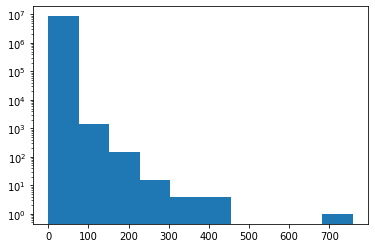

In [ ]:
data = data_handler.load_dataset('review')

plt.hist(data['useful'], log=True)
plt.show()

In [ ]:
data['usefulness'].value_counts()

not useful           8248608
moderately useful     369176
extremely useful       17619
Name: usefulness, dtype: int64

## Data retrieving

Ottenimento dei dati relativi alle reviews, bilanciati sulla base della classe rappresentante l'*utilità*.
In questo specifico caso, sono richiesti 30_000 samples per ogni classe (per un totale di 90_000 samples).

L'oggetto review_data contiene tre field relativi ai subdataset da utilizzare nel progetto:
- train_data = (x_train, y_train)
- val_data = (x_val, y_val)
- test_data = (x_test, y_test)

Alla prima esecuzione, i tre diversi subset sono salvati in files csv, in questo modo, nelle seguenti esecuzioni, tali file saranno letti senza dover rieseguire il codice di lettura e splitting dei dati.   

In [ ]:
review_data = Dataset('review', 'usefulness')

colums_to_keep = ['review_id','user_id','business_id','stars','useful','funny','cool','text','date','sentiment']

# 30_000 elements for each class
review_data.split(colums_to_keep, 'usefulness', val_size=0.1, test_size=0.1, n_samples=30_000)

## Data preprocessing and feature engineering

Fase di preparazione dei raw data ottenuti precedentemente.
Questa fase include attività di pulizia dei dati testuali (utilizzati dalle reti neurali LSTM e BERT) e di aggiunta di nuove features (input della Random Foest, KNN, SVM e MLP)

Ogni modello aggiungerà ulteriori azioni di processamento dei dati, se necessario, per adattarli al meglio al tipo di input atteso.


In [ ]:
# pulizia testo
prep_train_data = prep_utils.preprocess_texts(review_data.train_data[0]['text'], path= filenames.picked_cleaned_sentences(
        "train", "task3"))

prep_test_data = prep_utils.preprocess_texts(review_data.test_data[0]['text'], path= filenames.picked_cleaned_sentences(
        "test", "task3"))

prep_val_data = prep_utils.preprocess_texts(review_data.val_data[0]['text'], path= filenames.picked_cleaned_sentences(
        "val", "task3"))


Le nuove features calcolate sulla base dei dati relativi alle review e agli utenti che le hanno scritte sono:
- **compliment_count*: numero di complimenti ricevuti in totale dall'utente
- **elite_count*: numero di anni in cui l'utente ha fatto parte del gruppo elite di Yelp
- **friends_count*: numero di amici dell'utente
- **review_length*: lunghezza della review
- **readability*: leggibiià della review basata sul Flesch–Kincaid Grade Level
- **reading_time*: tempo stimato di lettura della review
- **polarity*: valore che varia tra il -1 e l'1 e rappresenta il sentimend della recensione 
- **subjectivity*: valore che varia tra lo 0 e l'1 e che rappresenta la soggettività della recensione


In [4]:
feat_lambdas = {
     'compliment_count' : lambda row: row.filter(regex="compliment_").sum(), # compliments count
     'elite_count': lambda row: 0 if row['elite'] == '' else len(row['elite'].split(sep=',')),
     'friends_count': lambda row: 0 if row['friends'] == '' else len(row['friends'].split(sep=',')),
     
     'review_length': lambda row: len(row['text'].split(sep=' ')),
     'readability': lambda row: textstat.flesch_kincaid_grade(row['text']),
     'reading_time': lambda row: textstat.reading_time(row['text']),

     'polarity': lambda row: TextBlob(row['text']).polarity,
     'subjectivity': lambda row: TextBlob(row ['text']).subjectivity
}

In [ ]:
user_data = data_handler.load_dataset('user')

train_data_feat = review_data.train_data[0].merge(user_data, on='user_id', suffixes= (None, '_user'))
val_data_feat = review_data.val_data[0].merge(user_data, on='user_id', suffixes= (None, '_user'))
test_data_feat = review_data.test_data[0].merge(user_data, on='user_id', suffixes= (None, '_user'))

Le features scelte come input generale dei modelli classici e delle MLP sono i seguenti.

In [35]:
complete_feat = [
    #  review features
    'stars', 'useful',
    'review_length',
    'readability', 'reading_time',
    'polarity', 'subjectivity',
    
    # user features
    'review_count', 'useful_user', 'average_stars',
    'compliment_count', 'elite_count',
    'fans','friends_count']

review_sub_feat = ['review_length',
    'readability', 'reading_time',
    'polarity', 'subjectivity'
]

Di seguito sono definiti i dati di per training, validation e testing contenenti le features scelte sopra (sia alcune già esistenti che altre create ai fini del progetto).

In [7]:
# for set_type, data in {'train': train_data_feat, 'val': val_data_feat, 'test': test_data_feat}.items():
#     data_handler.add_features(data, feat_lambdas, path = filenames.x_data_new_features('review', 'usefulness', set_type), to_csv=True)

train_data_feat = pd.read_csv(filenames.x_data_new_features('review', 'usefulness', 'train'), index_col=0)
val_data_feat = pd.read_csv(filenames.x_data_new_features('review', 'usefulness', 'val'), index_col=0)
test_data_feat = pd.read_csv(filenames.x_data_new_features('review', 'usefulness', 'test'), index_col=0)


## Training dei modelli

Per la risoluzione del problema visto come di classificazione sono stati testati numerosi approcci al fine di trovare il modello più performante. Le reti neurali **LSTM** e **BERT** sono state addestrate ricevendo come unico input il testo delle reviews, mentre gli algoritmi **Random Forest**, **KNN** e **MLP** hanno ricevuto in input diversi subset delle features generate e scelte precedentemente.

Per la risoluzione del problema come regressione, sono stati testati unicamente gli algoritmi **Random Forest**, **KNN** e **MLP**. Anche in questo caso, come per la classificazione, i modelli sono stati addestrati su dati caratterizzati dalle features precedentemente generate. 

In [36]:
scaler_complete_feat = StandardScaler()
scaler_complete_feat.fit(train_data_feat[complete_feat])

#  sclaer on training set without useful column 
reg_scaler_complete_feat = StandardScaler()
reg_scaler_complete_feat.fit(train_data_feat[complete_feat].drop('useful', axis=1))
1
scaler_review_feat = StandardScaler()
scaler_review_feat.fit(train_data_feat[review_sub_feat])

features_set_scaler = {
    'complete': (complete_feat, scaler_complete_feat),
    'review_only': (review_sub_feat, scaler_review_feat)
}

reg_features_set_scaler = {
    'complete': ([feat for feat in complete_feat if feat != 'useful'], reg_scaler_complete_feat),
    'review_only': (review_sub_feat, scaler_review_feat)
}

### Classificatori
Addestramento dei seguenti classificatori basati sui seguenti algoritmi:
- **KNN**
- **Random forest**
- **MLP**

Tutti questi modelli sono testati su due set diversi di dati, uno comprendente tutte le features scelte sopra, uno contenente solo le features relative alle caratteristiche del testo (soggettività, polarità, lunghezza...).

In [9]:
classifiers_res = []

#  classic machine learning algorithms
n_estimators_values = [100, 200, 500, 1000]
n_neighbors_values = [2, 20, 50, 100, 300, 500, 700, 1000]

#### Random Forest

Addestramento modelli basati su **Random Forest**, effettuando il tuning dell'iperparametro *n_estimator*.

In [ ]:
for feat_group_name, (features, _) in features_set_scaler.items():
    print(f'{feat_group_name}: {features}...')
    classifiers_res.extend([
        [
            'random forest', # nome del modello
            feat_group_name, # nome del gruppo di features
            {'n_estimators': n}, # params
            models_builders.train_model(RandomForestClassifier(n_estimators=n), # score 
            train_data_feat[features], review_data.train_data[1],
            val_data_feat[features], review_data.val_data[1])
    ]
        for n in n_estimators_values
    ])

#### KNN

Addestramento modelli basati su **KNN**, effettuando il tuning dell'iperparametro *n_neighbors*.

In [ ]:
for feat_group_name, (features, scaler) in features_set_scaler.items():
    print(f'{feat_group_name}: {features}...')

    x_data_train = scaler.transform(train_data_feat[features])
    x_data_val = scaler.transform(val_data_feat[features])

    classifiers_res.extend([
        [
            'knn',
            feat_group_name,
            {'n_neighbors': n},
            models_builders.train_model(KNeighborsClassifier(n_neighbors=n), 
            x_data_train, review_data.train_data[1],
            x_data_val, review_data.val_data[1])
        ]
        for n in n_neighbors_values
    ])

 #### MLP

Addestramento modelli di tipo **Multi Layer Perceptron**, effettuando il tuning degli iperparametri *learnig rate*, *quantità di layers* e *numero di neuroni per layer*. 

In questo caso il training della rete è eseguito solo sull'insieme più ampio di features.

In [ ]:
hs = [20, 50, 100] # hidden size
nl = {1, 2, 3, 5} # number of layer
lr = [0.001, 0.01] # learning rate

scaled_x_train = features_set_scaler['complete'][1].transform(train_data_feat[features_set_scaler['complete'][0]])
scaled_x_val = features_set_scaler['complete'][1].transform(val_data_feat[features_set_scaler['complete'][0]])

mlps_classifiers = []
for (hidden_size, number_layers, learning_rate) in itertools.product(hs, nl, lr):
    clf = MLPClassifier(
        hidden_layer_sizes=(hidden_size,)*number_layers,
        learning_rate_init=learning_rate,
        max_iter=500,
        early_stopping=True,
        random_state=const.seed,
        verbose=True).fit(scaled_x_train, review_data.train_data[1])

    mlps_classifiers.append(clf)
    score = clf.score(scaled_x_val, review_data.val_data[1])
    
    classifiers_res.append(['mlp', 'complete', {'hs': hidden_size, 'layers': number_layers, 'lr': learning_rate}, score])

Salvataggio risultati in un csv. 

In [16]:
pd.DataFrame(classifiers_res, columns = ['model', 'features_group', 'params', 'score']).to_csv("./results/task3_classifiers_results.csv")

Altri modelli di reti neurali testati per il problema di classificazione sono stati l'**LSTM** e **BERT**. In questo caso gli input utilizzati per addestrare la rete non sono caratterizzati dalle features precedentemente utilizzate ma sono rappresentati unicamente dal testo delle review (opportunamente pre-elaborato).

#### LSTM 
Sono state testate diverse architetture delle RNN di tipo LSTM, al fine di trovare la combinazione di iperparametri che rendono le migliori performance.

Riguardo il preprocessing aggiuntivo sui dati, è stato utilizzato un tokenizer specifico, il quale restituisce per ogni review un vettore contenente gli indici delle parole nel dizionario (estratto dalla collezione di reviews).

Tali indici sono fondamentali per il recupero delle word embedding corrispondenti alle parole delle reviews, azione che avviene nel layer di tipo Embedding impostato come primo layer della rete neurale.

In [ ]:
tokenizer = prep_utils.get_tokenizer(review_data.train_data[0]['text'])

train_tokens = prep_utils.get_set_tokens(
    review_data.train_data[0]['text'], tokenizer, set='train', task='task3')

test_tokens = prep_utils.get_set_tokens(
    review_data.test_data[0]['text'], tokenizer, set='test', task='task3')

val_tokens = prep_utils.get_set_tokens(
    review_data.val_data[0]['text'], tokenizer, set='val', task='task3')

Esistono diverse metodologie per la definizione dei word vectors, dal training di reti come Word2Vec all'utilizzo di mapping già pre-trained

Nel caso di questo studio è stato scelto di creare un'embedding matrix a partire da un mapping già esistente, nello specifico quello messo a disposizione da Glove e addestrato su una grande mole di dati testuali estratti da twitter.
Sulla base di questo mapping, sono stati estratti, ed inseriti in una matrice, i vettori delle parole presenti nel dizionario e, se non presenti, queste sono stati rappresentati come 0-vector.

In [ ]:
e_matrix = prep_utils.get_embedding_matrix(const.word_embedding_filepath, 'task3',
                                            tokenizer, len(tokenizer.index_word)+1)

word_vector_dim = 100

vocab_size = len(tokenizer.word_index)+1
max_length = len(max(train_tokens, key=len))

embedding_layer = Embedding(vocab_size, word_vector_dim,
                            embeddings_initializer=Constant(e_matrix), trainable=False)

Inizio fase di tuning degli iperparametri. 

Gli iperparametri testati sono:
- numero di units (dimensione del vettore delle celle e hidden states)
- percentuale di dropout
- learning rate

Il training è gestito utilizzando la tecnica dell'early stopping, definita dalla seguente callback, che termina il training dopo 5 epoche prive di miglioramenti.

In [7]:
# define custom callbacks
stop_early_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [ ]:
project_name = "task3_lstm_classifier_adam_32"

builder = models_builders.get_rnn_builder(
    drop=[0.2, 0.5],
    units=[50, 100, 200],
    lrate=[0.01, 0.001],
    optimizer=keras.optimizers.Adam,
    embedding_layer=embedding_layer,
    output_shape=3, # out classes
    activation='softmax',
    loss='categorical_crossentropy')

tuner = kt.RandomSearch(
    builder,
    objective = 'val_accuracy',
    max_trials = 10,
    directory = const.tuner_path, project_name = project_name
)

tuner.search_space_summary()

In [ ]:
tuner.search(train_tokens,
             pd.get_dummies(review_data.train_data[1]),
             batch_size=32, epochs=500,
             validation_data=(val_tokens, pd.get_dummies(review_data.val_data[1])),
             callbacks=[
                 stop_early_cb,
                 tf.keras.callbacks.TensorBoard(const.logs_path + project_name, update_freq='epoch')],
             verbose=0)


Il miglior modello trovato, in seguito ad entrambi il trainig , fornisce un'accuratezza sul validation set del 59.0% e del 64.3% sul training set. Tale modello si presenta come una rete con le seguenti caratteristiche:

- dropout del 50%
- learning rate di 0.001
- 100 units

Tutte le statistiche di esecuzione sono visualizzabili su tensorboard.

#### BERT
E' stata testata anche la tecnica BERT per questo task di classificazione, basandosi su un modello BERT pre-addestrato e procedendo con il suo fine-tuning.

Il modello scelto è stato scaricato da tensorflow-hub e consiste nella versione Small Bert, caratterizzara da un numero minore di transformer blocks.

In [5]:
handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

Preprocessing aggiuntivo dei dati già processati, wrapping delle review nell'oggetto Dataset.

In [6]:
#  prepariamo i dati per il classificatore
train_df = tf.data.Dataset.from_tensor_slices((prep_train_data, pd.get_dummies(review_data.train_data[1])))
val_df = tf.data.Dataset.from_tensor_slices((prep_val_data, pd.get_dummies(review_data.val_data[1])))

#  prepariamo i dati per il regressore
train_df_reg = tf.data.Dataset.from_tensor_slices((prep_train_data, review_data.train_data[0]['useful']))
val_df_reg= tf.data.Dataset.from_tensor_slices((prep_val_data, review_data.val_data[0]['useful']))

Definizione elementi utili per il training del modello.

In [7]:
epochs = 5

steps_per_epoch = tf.data.experimental.cardinality(train_df).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps, # lr decay
                                          optimizer_type='adamw')
                                          

In [8]:
model = models_builders.build_BERT_model(handle_preprocess, handle_encoder, 3, activation='softmax')

model.compile(optimizer=optimizer,
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

Training del modello.

L'accuratezza raggiunta sul training set è del 63.51% e sul validation set del 60%. 

In [ ]:
batch = 16

history = model.fit(x=train_df.batch(batch),
                    validation_data=val_df.batch(batch),
                    epochs=epochs,
                    callbacks=[tf.keras.callbacks.TensorBoard(const.logs_path + "task3_best_classifier_16", update_freq='epoch')])

Il testing del modello su test set ha raggiunto un'accuratezza del 59.79%.

In [ ]:
test_df = tf.data.Dataset.from_tensor_slices((prep_test_data, pd.get_dummies(review_data.test_data[1])))

loss, accuracy = model.evaluate(test_df.batch(1))

### Regressori
Per la risoluzione del problema visto come di regressione, sono stati testati i seguenti modelli:
- **KNN**
- **Random Forest**
- **MLP**

Come per la classificazione, i modelli sono testati su due set diversi di dati, uno comprendente tutte le features ed uno contenente solo quelle relative alle caratteristiche del testo (soggettività, polarità, lunghezza...).
A differenza dai training precedenti, sono stati invece selezionati solo 10_000 samples per il training e 5_000 per la validation.

Nel grafico di seguito è possibile osservare la distribuzione di vori 'useful' per il sottogruppo dei training samples.

In [24]:
regressors_res = []

#  classic machine learning algorithms
n_estimators_values = [100, 200, 500]
n_neighbors_values = [2, 20, 50, 100, 300, 500]

train_size = 10_000
val_size = 5_000

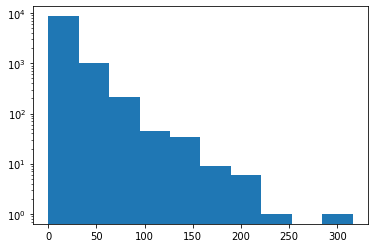

In [23]:
plt.hist(review_data.train_data[0].loc[:train_size, 'useful'], log=True)
plt.show()


#### Random Forest

Addestramento modelli basati su **Random Forest**, effettuando il tuning dell'iperparametro *n_estimator*.

In [25]:
for feat_group_name, (features, _) in features_set_scaler.items():
    print(f'{feat_group_name}: {features}...')
    regressors_res.extend([
        [
            'random forest', # nome del modello
            feat_group_name, # nome del gruppo di features
            {'n_estimators': n}, # params
            models_builders.train_model(RandomForestRegressor(n_estimators=n), # score 
            train_data_feat.loc[:train_size, features], review_data.train_data[0].loc[:train_size, 'useful'],
            val_data_feat.loc[:val_size, features], review_data.val_data[0].loc[:val_size, 'useful'])
    ]
        for n in n_estimators_values
    ])

complete: ['stars', 'review_length', 'readability', 'reading_time', 'polarity', 'subjectivity', 'review_count', 'useful_user', 'average_stars', 'compliment_count', 'elite_count', 'fans', 'friends_count']...
	-0.05678711983036444 accuracy
	-0.05802059626132583 accuracy
	-0.051570147011602785 accuracy
review_only: ['review_length', 'readability', 'reading_time', 'polarity', 'subjectivity']...
	-0.079353629097622 accuracy
	-0.07451696776386973 accuracy
	-0.06900608395881402 accuracy


#### KNN

Addestramento modelli basati su **KNN**, effettuando il tuning dell'iperparametro *n_neighbors*.

In [38]:
for feat_group_name, (features, scaler) in reg_features_set_scaler.items():
    print(f'{feat_group_name}: {features}...')
    
    x_data_train = scaler.transform(train_data_feat.loc[:train_size, features])
    x_data_val = scaler.transform(val_data_feat.loc[:val_size, features])

    regressors_res.extend([
        [
            'knn',
            feat_group_name,
            {'n_neighbors': n},
            models_builders.train_model(KNeighborsRegressor(n_neighbors=n), 
            x_data_train, review_data.train_data[0].loc[:train_size, 'useful'],
            x_data_val, review_data.val_data[0].loc[:val_size, 'useful'])
        ]
        for n in n_neighbors_values
    ])

complete: ['stars', 'review_length', 'readability', 'reading_time', 'polarity', 'subjectivity', 'review_count', 'useful_user', 'average_stars', 'compliment_count', 'elite_count', 'fans', 'friends_count']...
	-0.45650458984608333 accuracy
	-0.03170437920686475 accuracy
	-0.012957276011120289 accuracy
	-0.003320755474629289 accuracy
	0.0009820211779534294 accuracy
	-0.0009167849106836989 accuracy
review_only: ['review_length', 'readability', 'reading_time', 'polarity', 'subjectivity']...
	-0.4770800722403017 accuracy
	-0.04841607871383946 accuracy
	-0.01972521899473989 accuracy
	-0.008224754602192075 accuracy
	-0.005790700556731032 accuracy
	-0.002023679424315583 accuracy


 #### MLP

Addestramento modelli di tipo **Multi Layer Perceptron**, effettuando il tuning degli iperparametri *learnig rate*, *quantità di layers* e *numero di neuroni per layer*. 

In questo caso il training della rete è eseguito solo sull'insieme più ampio di features.

In [ ]:
hs = [20, 50, 100] # hidden size
nl = {1, 2, 3, 5} # number of layer
lr = [0.001, 0.01] # learning rate

scaled_x_train = reg_features_set_scaler['complete'][1].transform(train_data_feat.loc[:train_size, reg_features_set_scaler['complete'][0]])
scaled_x_val = reg_features_set_scaler['complete'][1].transform(val_data_feat.loc[:val_size, reg_features_set_scaler['complete'][0]])

for (hidden_size, number_layers, learning_rate) in itertools.product(hs, nl, lr):
    reg = MLPRegressor(
        hidden_layer_sizes=(hidden_size,)*number_layers,
        learning_rate_init=learning_rate,
        max_iter=500,
        early_stopping=True,
        random_state=const.seed,
        verbose=True).fit(scaled_x_train, review_data.train_data[0].loc[:train_size,'useful'])

    score = reg.score(scaled_x_val, review_data.val_data[0].loc[:val_size, 'useful'])
    
    regressors_res.append(['mlp', 'complete', {'hs': hidden_size, 'layers': number_layers, 'lr': learning_rate}, score])

Salvataggio dei risultati in un csv.

In [40]:
pd.DataFrame(regressors_res, columns = ['model', 'features_group', 'params', 'r2_score']).to_csv("./results/task3_regressors_results.csv")